# Abstract

The main finding of this project was that it is hard to create a model that will predict the outcome of a randomly generated dataset. The dataset used in this project seemed to have a randomly generated target variable, "Class" which made model fitting difficult. Attempting to keep too many potentially redundant features results in poor accuracies that can appear closer to random guessing. I used the decision tree classifier, random forest classifier, K-nearest neighbors, and Naive Bayes for this project. I learned about hyperparameters and how to adjust them to best fit the data.

The next steps would be to explore other types of models that may be able to better predict the data. I would be interested to try this again on a better dataset, followed by tweaking the resulting model with domain knowledge to see how this bit of information affects my decisions on the model.

# Overview

Problem statement: The objective of this project is to build a model and pipeline that can accurately predict the target variable using the dataset's features.

Proposed methodology: The first step will be an exploratory analysis to get familiar with the data. The model will then use PCA on scaled data to reduce the dimensionality. A classifier will be chosen based on best fit. Finally the appropriate steps will be tied together in an ONNX pipeline.

# Data Processing and Analysis

In [1]:
# PMML
!pip install sklearn2pmml

# ONNX
!pip install skl2onnx
!pip install onnxruntime

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
%matplotlib inline

from sklearn import tree
import graphviz
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import math


import onnxruntime as rt
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score

# from feature_selector import FeatureSelector
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from mlxtend.feature_selection import ColumnSelector
from sklearn.compose import ColumnTransformer
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

# from onnxmltools.convert.common.shape_calculator import calculate_linear_classifier_output_shapes
# from skl2onnx.operator_converters.RandomForest import convert_sklearn_random_forest_classifier

/usr/local/lib/python3.10/dist-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/usr/local/lib/python3.10/dist-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/usr/local/lib/python3.10/dist-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import data to df
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/422 Project/data_public.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', na_values='?')
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O']

In [5]:
# get some initial information about the dataset
# show first few rows
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


In [6]:
# datatypes, missing values, number of items, etc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB


There are 1.2 million records and the same number of non-null values for all features, meaning no missing values.

In [7]:
# stats
df.describe()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,5.068656e+01,-1.883373e+01,7.162152e+01,-1.355120e+01,2.944177e+01,-6.185189e+00,3.174186e+01,5.112504e+01,3.300077e+01,4.092546e+01,7.938340e+01,-6.746540e+00,-4.232290e+01,4.949012e+01,5.980333e+01,2.167323e+00
std,1.292492e+02,1.446355e+01,1.052808e+02,4.689774e+01,7.282278e+01,7.309100e+01,6.660329e+01,1.034053e+02,4.217119e+01,7.694386e+01,9.484003e+01,1.557490e+01,1.791142e+01,6.728231e+01,6.677712e+01,6.874930e-01
min,-7.308940e+01,-8.322357e+01,-5.972853e+01,-1.375818e+02,-3.829826e+01,-1.485917e+02,-6.654137e+01,-4.246089e+01,-1.818542e+01,-1.123844e+02,-1.415233e+01,-6.271828e+01,-8.144988e+01,-2.057979e+01,-1.283059e+01,1.000000e+00
25%,-3.793679e+01,-1.786669e+01,7.553164e+00,-1.471337e+01,-2.436286e+01,-3.072492e+01,-3.484185e+00,-2.629661e+01,-7.594991e+00,2.108044e+01,2.419273e+00,-8.875128e+00,-5.567326e+01,-7.131906e+00,1.628438e-01,2.000000e+00
50%,-3.197847e+01,-1.369876e+01,1.348796e+01,-8.004308e+00,-1.897058e+01,-2.475391e+01,1.491431e+00,-1.817028e+01,3.769369e+01,2.717432e+01,2.652955e+01,-1.079123e+00,-5.297585e+01,1.462293e+01,4.689262e+01,2.000000e+00
75%,2.280020e+02,-1.055606e+01,2.123439e+02,1.955806e+01,1.289018e+02,7.834417e+01,1.151840e+02,1.915891e+02,7.984842e+01,1.253846e+02,2.046458e+02,3.334451e+00,-2.208504e+01,1.363603e+02,1.451293e+02,3.000000e+00
max,2.687738e+02,4.460108e+00,2.561698e+02,3.263799e+01,1.579843e+02,1.229186e+02,1.660534e+02,2.329496e+02,1.112970e+02,1.755397e+02,2.598003e+02,2.159496e+01,1.032828e+01,1.789303e+02,1.807011e+02,3.000000e+00


In [8]:
# scale df to remove sparsity
df_scaled = pd.DataFrame(data=preprocessing.scale(df), columns=df.columns)

# class column is not continuous, put back original
df_scaled['Class'] = df['Class']
df_scaled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,1.398333,0.457892,1.386800,-0.043941,1.518831,1.136805,1.499176,1.421937,1.182621,1.123217,1.531100,0.048383,1.542774,1.390885,1.402222,2
1,-0.686316,0.320671,-0.589262,0.764323,-0.755534,-0.166762,-0.477999,-0.820431,-0.980689,-0.222670,-0.792750,0.613532,-0.949550,-0.909245,-0.875843,3
2,-0.695429,-0.109594,-0.480605,0.710940,-0.759987,-0.177913,-0.520931,-0.739075,-0.939343,-0.190270,-0.774695,0.830704,-0.815240,-0.805046,-0.910959,2
3,1.322591,0.902156,1.378256,0.077838,1.336854,1.249231,1.157837,1.416902,1.175193,1.509929,1.408750,0.200674,1.499253,1.274864,1.338920,2
4,1.376193,0.441525,1.263438,0.005832,1.503497,1.331041,1.259054,1.529661,1.350708,1.161552,1.290718,0.332113,1.518267,1.469607,1.313165,3


In [9]:
# suppress scientific notation
df_scaled.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
count,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000,1200000.00000
mean,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,2.16732
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.68749
min,-0.95765,-4.45187,-1.24762,-2.64471,-0.93020,-1.94835,-1.47565,-0.90504,-1.21377,-1.99249,-0.98625,-3.59372,-2.18447,-1.04143,-1.08771,1.00000
25%,-0.68568,0.06686,-0.60855,-0.02478,-0.73884,-0.33574,-0.52889,-0.74872,-0.96264,-0.25792,-0.81152,-0.13667,-0.74536,-0.84156,-0.89313,2.00000
50%,-0.63958,0.35503,-0.55218,0.11828,-0.66480,-0.25405,-0.45419,-0.67013,0.11128,-0.17872,-0.55729,0.36388,-0.59476,-0.51822,-0.19334,2.00000
75%,1.37189,0.57231,1.33664,0.70599,1.36578,1.15650,1.25282,1.35838,1.11089,1.09767,1.32078,0.64726,1.12989,1.29113,1.27777,3.00000
max,1.68734,1.61052,1.75292,0.98489,1.76514,1.76634,2.01659,1.75837,1.85663,1.74951,1.90233,1.81969,2.93953,1.92384,1.81047,3.00000


I'll start with doing an exploratory analysis to visualize the data. Following the same method as the example, I'll visualize each feature as a histogram.

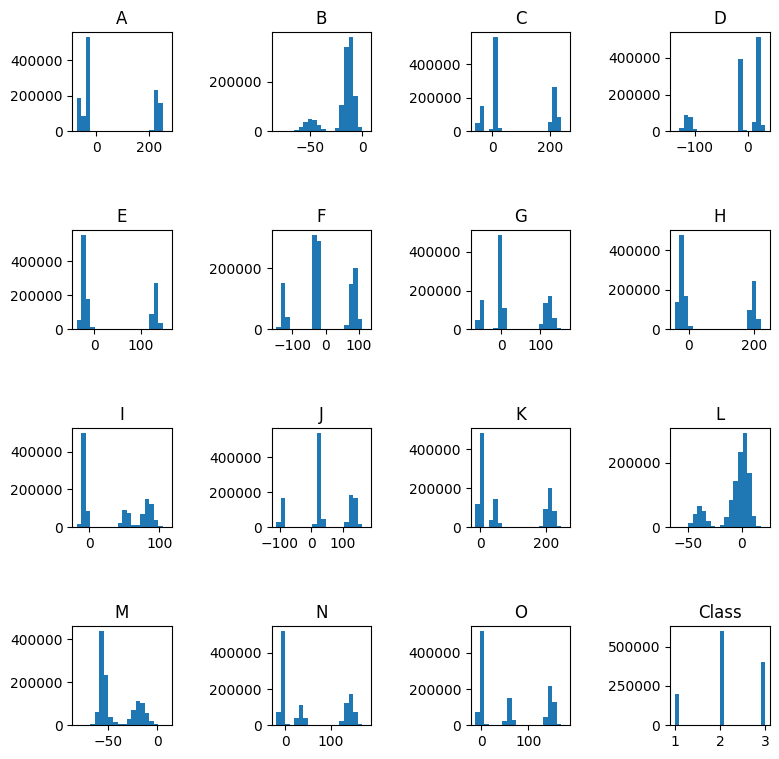

In [10]:
# Histograms
features = 'ABCDEFGHIJKLMNO'
plot = plt.figure()

for i in range(1,16):
    plot.add_subplot(4,4,i)
    plt.hist(df[features[i-1:i]], bins=20)
    plt.title(features[i-1:i])

plot.add_subplot(4,4,16)
plt.hist(df['Class'], bins=20)
plt.title('Class')
plot.subplots_adjust(hspace=1, wspace=1)
plot.set_figheight(9)
plot.set_figwidth(9)

Here are histograms for the scaled data:

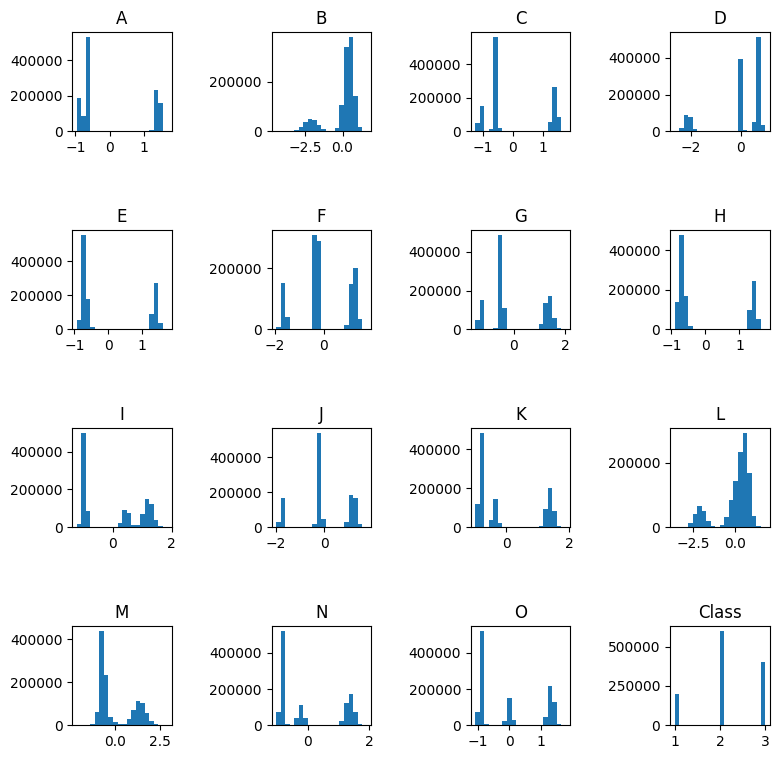

In [11]:
# df_scaled histograms
plot = plt.figure()

for i in range(1,16):
    plot.add_subplot(4,4,i)
    plt.hist(df_scaled[features[i-1:i]], bins=20)
    plt.title(features[i-1:i])

plot.add_subplot(4,4,16)
plt.hist(df_scaled['Class'], bins=20)
plt.title('Class')
plot.subplots_adjust(hspace=1, wspace=1)
plot.set_figheight(9)
plot.set_figwidth(9)

I'll also visualize the basic statistics of each feature using box plots.

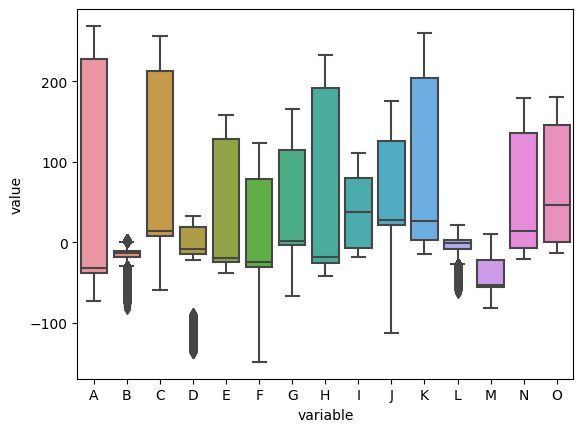

In [12]:
# Box plots for each feature
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,:15]))
plt.show()

Features B, D, and L have a number of outliers since most of the data is centered near the mean. The spread of these features is not as large as the others.

Now I will explore the correlation of each feature to the other features in the dataset.

In [13]:
# get correlation info
df.corr('pearson')

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.455949,0.991999,0.071330,0.990703,0.905353,0.972223,0.988807,0.818399,0.870016,0.968827,0.139619,0.958931,0.953081,0.920322,-0.000620
B,0.455949,1.000000,0.541742,0.865856,0.352946,0.760708,0.620607,0.339549,-0.098558,0.803246,0.246429,0.854635,0.345030,0.194578,0.098805,0.000138
C,0.991999,0.541742,1.000000,0.176224,0.971805,0.943482,0.988351,0.968342,0.753474,0.915784,0.937868,0.238723,0.941040,0.916578,0.873800,-0.000686
D,0.071330,0.865856,0.176224,1.000000,-0.047459,0.477183,0.279248,-0.062451,-0.502643,0.544357,-0.163679,0.949485,-0.042057,-0.217856,-0.316241,0.000150
E,0.990703,0.352946,0.971805,-0.047459,1.000000,0.849129,0.939705,0.997116,0.879142,0.805749,0.989217,0.026319,0.964769,0.979925,0.958885,-0.000649
F,0.905353,0.760708,0.943482,0.477183,0.849129,1.000000,0.969055,0.841227,0.508345,0.989868,0.781534,0.518117,0.823551,0.745156,0.675416,-0.000540
G,0.972223,0.620607,0.988351,0.279248,0.939705,0.969055,1.000000,0.934714,0.678043,0.949429,0.894114,0.335039,0.910385,0.867546,0.815281,-0.000472
H,0.988807,0.339549,0.968342,-0.062451,0.997116,0.841227,0.934714,1.000000,0.886017,0.796856,0.990875,0.012005,0.964627,0.982403,0.962873,-0.000670
I,0.818399,-0.098558,0.753474,-0.502643,0.879142,0.508345,0.678043,0.886017,1.000000,0.439881,0.926217,-0.418110,0.848801,0.943365,0.970965,-0.000766
J,0.870016,0.803246,0.915784,0.544357,0.805749,0.989868,0.949429,0.796856,0.439881,1.000000,0.730841,0.579309,0.781815,0.691273,0.615931,-0.000333


A heatmap makes the correlation coefficients easier to visualize.

<Axes: >

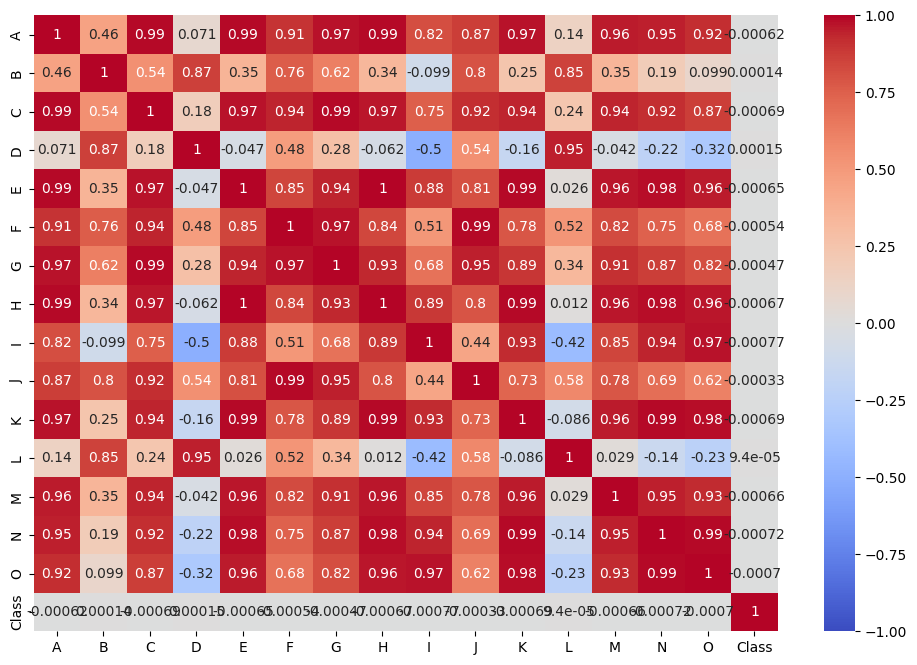

In [14]:
# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr('pearson'), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

It looks like there are a few feature pairs that are well correlated and others that can be dropped. For instance A, C, E, H, K, M, N, and O seem to be highly correlated to each other. Meanwhile B, D, and L seem to have low correlation with most other features but have a higher correlation amongst themselves. This is also consistent with the boxplots. Coupled with the histograms, here are groupings based on visual similarities that are potentially related:

* A, E, H
* B, D, L
* C, G, J
* F
* K, K
* I, O
* M

D and L specifically appear to have colinearities.



To find the features to drop, I use the source code found in the example project. First I will need to split the data into training and testing sets to get the optimal number of principal components.

In [15]:
# split the scaled df into training and testing data
x = pd.DataFrame(data=df_scaled.drop('Class', axis=1), columns=labels)
y = pd.DataFrame(data=df_scaled['Class'], columns=['Class'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
training_data = pd.concat([x_train, y_train], axis=1)
training_data.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
309088,-0.658664,0.530378,-0.544267,0.756309,-0.740273,-0.286311,-0.463360,-0.746300,-0.990163,-0.300590,-0.863793,0.602367,-0.872376,-0.802150,-0.911982,1
649361,-0.886239,-1.688681,-1.095152,-1.949161,-0.664945,-1.628498,-1.311157,-0.646845,0.487321,-1.705768,-0.224830,-1.943961,-0.648550,-0.312729,-0.068430,2
481643,1.398808,0.843661,1.406978,-0.047030,1.362367,1.300943,1.303804,1.474336,1.155883,1.264797,1.498507,0.185396,1.710283,1.346089,1.327907,2
17495,-0.613446,0.176390,-0.570406,0.546473,-0.733468,-0.317449,-0.540430,-0.759414,-1.001915,-0.187791,-0.819530,0.401266,-0.836676,-0.884084,-0.947830,3
366635,-0.657892,0.358901,-0.652124,0.802752,-0.686615,-0.217595,-0.506537,-0.740396,-1.028627,-0.238692,-0.775463,0.262140,-0.745867,-0.830767,-0.904402,3


Similar to the example project, I used a scree plot to identify the optimal number of principal components to explain 95% of the variance. The code can be found here: https://statisticsglobe.com/scree-plot-pca-python

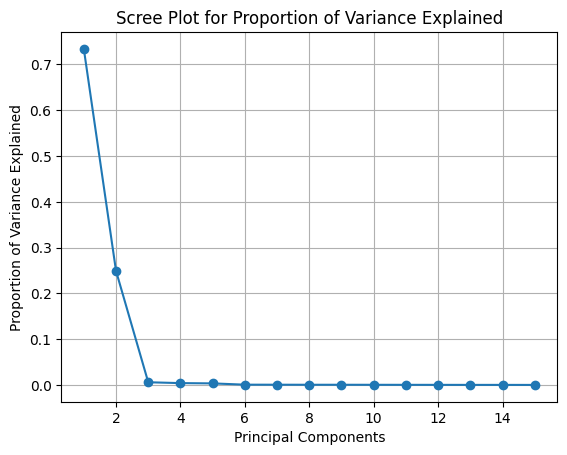

In [16]:
# PCA - dimensionality reduction
pca = PCA(n_components=15)
pca.fit(df_scaled.drop('Class', axis=1))

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.plot(np.arange(1, len(prop_var)+1), prop_var, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot for Proportion of Variance Explained')
plt.grid(True)

The elbow occurs at n=3, indicating 3 is the optimal number of dimensions. Now I will use this as the new n_components for PCA in the pipeline defined in the example project.

In [17]:
pca3 = PCA(n_components=3)
dtc = DecisionTreeClassifier(max_depth=3, random_state=42)

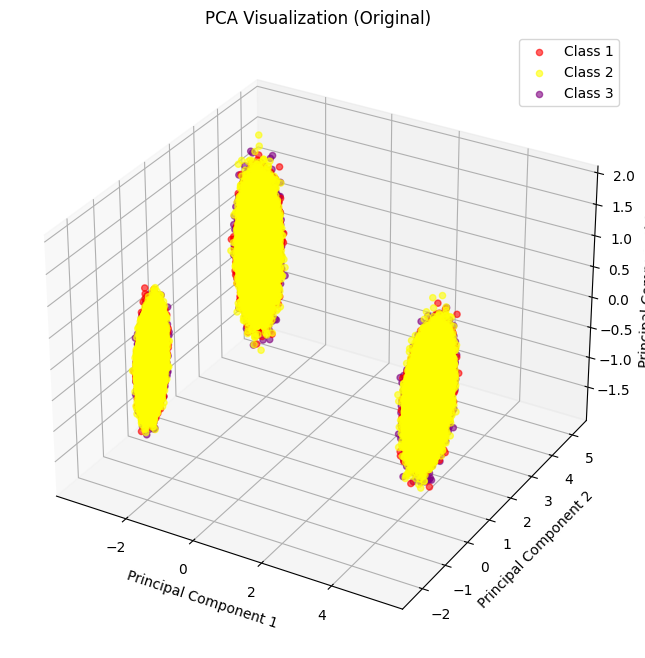

In [18]:
# Visualize the data with 3 PC
pca3_fitted = pca3.fit_transform(x, y)

pca3_df = pd.DataFrame(data=pca3_fitted, columns=[f"PC{i+1}" for i in range(3)])
pca3_df['Class'] = df['Class']

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
classes = np.unique(pca3_df['Class'])
colors = ['red', 'yellow', 'purple']

for cls, color in zip(classes, colors):
    ax.scatter(pca3_df.loc[pca3_df['Class'] == cls, 'PC1'],
               pca3_df.loc[pca3_df['Class'] == cls, 'PC2'],
               pca3_df.loc[pca3_df['Class'] == cls, 'PC3'],
               c=color, label=f'Class {cls}', alpha=0.6)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Visualization (Original)')
ax.legend()
plt.show()

Class 2 contributes the most to each cluster which can be an issue if we are interested in the other classes.

# Model Training and Validation

In [19]:
# modified code from example project using 3 principal components
# and random_state=42 for reproducibility
for feature in features:
    pipeline = PMMLPipeline([
        ('mapper', DataFrameMapper([(x_train.columns.drop([feature]).values, [StandardScaler()])])),
        ('pca', pca3),
        ('classifier', dtc)])
    pipeline.fit(training_data.drop([feature], axis=1), training_data['Class'])
    results = pipeline.predict(x_test)
    actual = np.concatenate(y_test.values)
    accuracy = accuracy_score(actual, results)
    print('Dropped feature:', feature, ', Accuracy:', accuracy)

Dropped feature: A , Accuracy: 0.4998458333333333
Dropped feature: B , Accuracy: 0.49992916666666665
Dropped feature: C , Accuracy: 0.49985833333333335
Dropped feature: D , Accuracy: 0.4998458333333333
Dropped feature: E , Accuracy: 0.4999208333333333
Dropped feature: F , Accuracy: 0.49990416666666665
Dropped feature: G , Accuracy: 0.4999166666666667
Dropped feature: H , Accuracy: 0.4998958333333333
Dropped feature: I , Accuracy: 0.49988333333333335
Dropped feature: J , Accuracy: 0.4998916666666667
Dropped feature: K , Accuracy: 0.4999
Dropped feature: L , Accuracy: 0.4999166666666667
Dropped feature: M , Accuracy: 0.4999208333333333
Dropped feature: N , Accuracy: 0.49988333333333335
Dropped feature: O , Accuracy: 0.49992916666666665


It is quickly apparent that removing any single feature has little effect on the decision tree's performance. This confirms that many of the features are either highly correlated to others or redundant which means the tree draws a similar conclusion using other correlated features. The accuracy is just under 50% regardless of which feature is removed, which is as good as randomly guessing.

Since the decision tree performed poorly, I attempted random forest, K-nearest neighbors, Naive Bayes, and Gradient Boosting models as these were identified as popular multi-class algorithms in this website: https://machinelearningmastery.com/types-of-classification-in-machine-learning/

In [20]:
# Models to be tested (Random Forest, K-Nearest Neighbors, Naive Bayes, Gradient Boosting)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=10, random_state=42)
}

# Brute force loop to try all combinations of models
for feature in features:
    for model_name, model in models.items():
        pipeline = PMMLPipeline([
            ('mapper', DataFrameMapper([(x_train.columns.drop([feature]).values, [StandardScaler()])])),
            ('pca', PCA(n_components=3)),
            ('classifier', model)])
        pipeline.fit(x_train.drop([feature], axis=1), training_data['Class'])
        results = pipeline.predict(x_test)
        actual = np.concatenate(y_test.values)
        accuracy = accuracy_score(actual, results)
        print('Dropped feature:', feature, ', Accuracy:', accuracy, ', Model:', model_name)
    print('\n')


Dropped feature: A , Accuracy: 0.49992916666666665 , Model: Random Forest
Dropped feature: A , Accuracy: 0.4142208333333333 , Model: K-Nearest Neighbors
Dropped feature: A , Accuracy: 0.49992916666666665 , Model: Naive Bayes
Dropped feature: A , Accuracy: 0.49992916666666665 , Model: Gradient Boosting


Dropped feature: B , Accuracy: 0.49992916666666665 , Model: Random Forest
Dropped feature: B , Accuracy: 0.4153375 , Model: K-Nearest Neighbors
Dropped feature: B , Accuracy: 0.49992916666666665 , Model: Naive Bayes
Dropped feature: B , Accuracy: 0.499925 , Model: Gradient Boosting


Dropped feature: C , Accuracy: 0.49992916666666665 , Model: Random Forest
Dropped feature: C , Accuracy: 0.4135625 , Model: K-Nearest Neighbors
Dropped feature: C , Accuracy: 0.49992916666666665 , Model: Naive Bayes
Dropped feature: C , Accuracy: 0.49992916666666665 , Model: Gradient Boosting


Dropped feature: D , Accuracy: 0.49992916666666665 , Model: Random Forest
Dropped feature: D , Accuracy: 0.4152458

All of these models also produced poor accuracies so I will assess the importance of each feature. I do this by following the method described in the provided example.

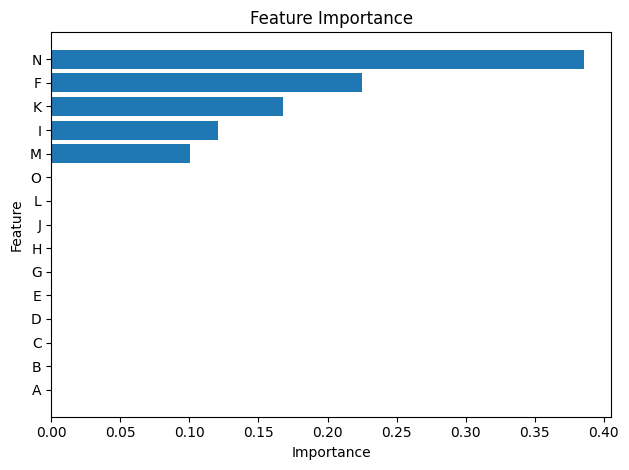

In [21]:
# fit decision tree
dtc.fit(x, y)

# get features and store to a df then sort in descending order
feature_importance = dtc.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# plot
plt.figure()
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

The most important features are N, F, K, I, and M. I will test these features using a random forest classifier.

In [22]:
# get combinations of the most important features (N, F, K, I, M)
N = 'N'
F = 'F'
K = 'K'
I = 'I'
M = 'M'

nfkim = N + F + K + I + M
size = 4
combos = list(combinations(nfkim, size))

for combo in combos:
    print(''.join(combo))

NFKI
NFKM
NFIM
NKIM
FKIM


I tested all subsets of the previously attained most important features.

In [23]:
# All possible subsets of N,F,K,I,M
to_test = [['N'], ['F'],['K'],['I'],['M'],
           ['N','F'],['N','K'],['N','I'],['N','M'] ,
           ['F','K'],['F','I'],['F','M'],
           ['K','I'],['K','M'],
           ['I','M'],
           ['N','F','K'],['N','F','I'],['N','F','M'],
           ['N','K','I'],['N','K','M'],
           ['N','I','M'],
           ['F','K','I'],['F','K','M'],
           ['K','I','M'],
           ['F','K','I'],
           ['N','F','K','I'],['N','F','K','M'],
           ['N','F','I','M'],['N','F','I','M'],
           ['F','K','I','M']]

for to_keep in to_test:
    pipeline1 = PMMLPipeline([
        ('mapper', DataFrameMapper([(x_train[to_keep].columns, [StandardScaler()])])),
         ('pca', PCA(n_components=1)),
          ('classifier', RandomForestClassifier(max_depth=2,n_estimators=10))
          ])
    pipeline1.fit(training_data, training_data['Class'])
    results = pipeline1.predict(x_test)
    actual = np.concatenate(y_test.values)
    print('Feature(s) tested:',to_keep, 'Accuracy:', metrics.accuracy_score(actual, results))

Feature(s) tested: ['N'] Accuracy: 0.49992916666666665
Feature(s) tested: ['F'] Accuracy: 0.49992916666666665
Feature(s) tested: ['K'] Accuracy: 0.49992916666666665
Feature(s) tested: ['I'] Accuracy: 0.49992916666666665
Feature(s) tested: ['M'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'F'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'K'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'I'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'M'] Accuracy: 0.49992916666666665
Feature(s) tested: ['F', 'K'] Accuracy: 0.49992916666666665
Feature(s) tested: ['F', 'I'] Accuracy: 0.49992916666666665
Feature(s) tested: ['F', 'M'] Accuracy: 0.49992916666666665
Feature(s) tested: ['K', 'I'] Accuracy: 0.49992916666666665
Feature(s) tested: ['K', 'M'] Accuracy: 0.49992916666666665
Feature(s) tested: ['I', 'M'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'F', 'K'] Accuracy: 0.49992916666666665
Feature(s) tested: ['N', 'F', 'I'] Accuracy: 0.4999291666666

At this point I am suspecting that the data points were randomly assigned to a class for a couple reasons. First, no matter what feature is dropped the accuracy is similar. Even using the identified "most important" features, there is little predictive power. Additionally, features A through O have the same correlation coefficients and descriptive statistics as the example project, indicating an identical dataset. However, the 'Class' feature has completely different correlation coefficients. To test my theory, I will perform a label shuffling and re-assess the decision tree model's accuracy.

In [24]:
# shuffle with a set random_state
shuffled_labels = df['Class'].sample(frac=1, random_state=0).reset_index(drop=True)

# reassign classes
df_shuffled = df.drop('Class', axis=1).assign(Class=shuffled_labels)
df_shuffled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,2


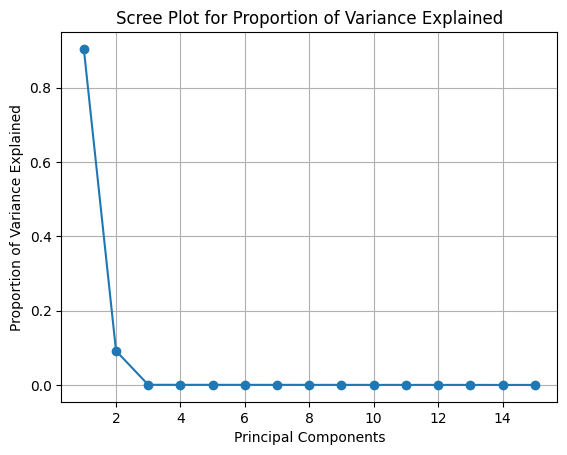

In [25]:
# PCA - dimensionality reduction
pca = PCA(n_components=15)
pca.fit(df_shuffled.drop('Class', axis=1))

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.plot(np.arange(1, len(prop_var)+1), prop_var, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot for Proportion of Variance Explained')
plt.grid(True)

The optimal number of principal components is still 3.

In [26]:
# shuffled training and test data
x_s = pd.DataFrame(data=df_shuffled.drop('Class', axis=1), columns=labels)
y_s = pd.DataFrame(data=df_shuffled['Class'], columns=['Class'])

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_s, y_s, test_size=0.2)
training_data_shuffled = pd.concat([x_train_s, y_train_s], axis=1)
training_data_shuffled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
718813,-37.674866,-18.330003,19.918500,17.701436,-17.724901,-23.688562,1.301660,-20.060560,-5.771186,24.281413,2.471570,-1.023472,-52.436448,-5.691803,1.970369,2
1074822,-38.952068,-15.579259,16.059328,24.393227,-28.435521,-23.856881,6.887861,-25.704193,-8.361549,22.458576,0.595809,-1.153564,-53.941989,-7.388071,0.464979,1
1081054,-63.965767,-34.392392,-44.248701,-115.187419,-17.847948,-127.173472,-51.764247,-4.283806,54.158514,-92.033059,47.022888,-36.851114,-51.641273,28.745597,59.362426,2
854765,229.245591,-12.781835,213.642965,-15.278465,138.824442,73.522281,118.745325,203.429362,85.989586,121.462646,202.769223,-16.292830,-23.157629,138.639451,142.206846,3
684333,-32.349255,-8.448684,12.749214,20.069896,-22.025679,-26.385969,-2.323731,-24.392679,-8.548654,23.010868,3.403018,3.441890,-54.303257,-3.172573,-1.701283,1


In [27]:
dtc_s = DecisionTreeClassifier(max_depth=3, random_state=42)
dtc_s.fit(x_s, y_s)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [28]:
# Using the shuffled data, re-perform the decision tree with dropped features
for feature in features:
    pipeline = PMMLPipeline([
        ('mapper', DataFrameMapper([(x_train_s.columns.drop([feature]).values, [StandardScaler()])])),
        ('pca', pca3),
        ('classifier', dtc_s)])
    pipeline.fit(training_data_shuffled.drop([feature], axis=1), training_data_shuffled['Class'])
    results = pipeline.predict(x_test_s)
    actual = np.concatenate(y_test_s.values)
    accuracy = accuracy_score(actual, results)
    print('Dropped feature:', feature, ', Accuracy:', accuracy)

Dropped feature: A , Accuracy: 0.49942916666666665
Dropped feature: B , Accuracy: 0.4994
Dropped feature: C , Accuracy: 0.4994416666666667
Dropped feature: D , Accuracy: 0.49945833333333334
Dropped feature: E , Accuracy: 0.4994708333333333
Dropped feature: F , Accuracy: 0.4994166666666667
Dropped feature: G , Accuracy: 0.49945833333333334
Dropped feature: H , Accuracy: 0.49937916666666665
Dropped feature: I , Accuracy: 0.499475
Dropped feature: J , Accuracy: 0.4994708333333333
Dropped feature: K , Accuracy: 0.4994708333333333
Dropped feature: L , Accuracy: 0.499475
Dropped feature: M , Accuracy: 0.49945
Dropped feature: N , Accuracy: 0.499475
Dropped feature: O , Accuracy: 0.4994


With randomly assigned labels, the accuracies hover around 0.499 which is about the same as the original data. This is still as good as random guessing.

For the ONNX pipeline, I'll return to the decision tree classifier with an optimized max depth because it produced the highest accuracy out of all the models tested.

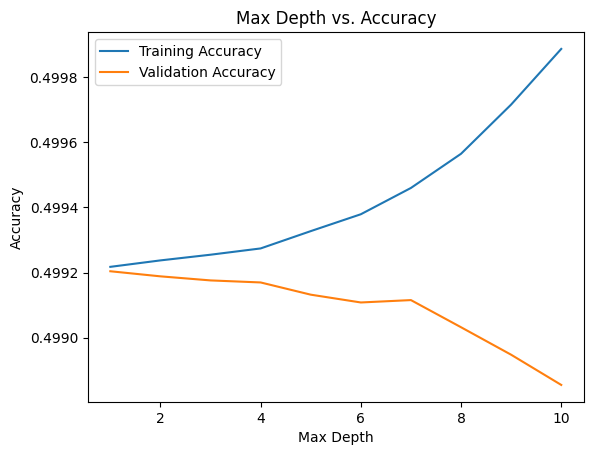

In [29]:
max_depths = np.arange(1, 11)

# lists to store the results
train_accuracy = []
val_accuracy = []

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # cross-validation to evaluate the model
    cv_results = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)

    # average training and validation accuracy
    avg_train_accuracy = np.mean(cv_results['train_score'])
    avg_val_accuracy = np.mean(cv_results['test_score'])

    # store to list for plotting
    train_accuracy.append(avg_train_accuracy)
    val_accuracy.append(avg_val_accuracy)

plt.plot(max_depths, train_accuracy, label='Training Accuracy')
plt.plot(max_depths, val_accuracy, label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Max Depth vs. Accuracy')
plt.show()

The max depth seems to have minimal effect on accuracy as the data immediately diverges and produces accuracies ranging from 0.4990 to 0.4998. I will use max_depth=2 since anything greater is less accurate.

Below is the final pipeline:

input ⟶ scaling ⟶ PCA(n_component=3) ⟶ decision tree(max_depth=2) ⟶ output

In [30]:
# split the scaled df into training and testing data
x = pd.DataFrame(data=df.drop('Class', axis=1), columns=labels)
y = pd.DataFrame(data=df['Class'], columns=['Class'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
training_data = pd.concat([x_train, y_train], axis=1)
training_data.head()

# pipeline
pipeline = PMMLPipeline([
    ('mapper', DataFrameMapper([(x_train.columns.values,StandardScaler())])),
    ('pca', PCA(n_components=3)),
    ('classifier', DecisionTreeClassifier(max_depth=2))
    ])

# fit
pipeline.fit(x_train,y_train.values.ravel());

# predict
prediction = pipeline.predict(x_test)
print('Accuracy = ', metrics.accuracy_score(y_test.values.ravel(),prediction))

/usr/local/lib/python3.10/dist-packages/sklearn2pmml/pipeline/__init__.py:75: UserWarning: y is missing target field name(s)
  warnings.warn("y is missing target field name(s)")


Accuracy =  0.5003875


ONNX Pipeline

In [31]:
pca = PCA(n_components=3)
classifier = DecisionTreeClassifier(max_depth=2)

onnx_pipeline = Pipeline([
    ('precprocessor', ColumnTransformer(transformers=[
        ('feature', Pipeline(steps=[
            ('scaler', StandardScaler())
            ]),
         df.columns[:15])
        ])
    ),
    ('pca', pca),
    ('classifier', classifier)
])

onnx_pipeline.fit(x_train,y_train);
print(classification_report(onnx_pipeline.predict(x_train),y_train))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67    960000
           3       0.00      0.00      0.00         0

    accuracy                           0.50    960000
   macro avg       0.33      0.17      0.22    960000
weighted avg       1.00      0.50      0.67    960000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
cross_validate(onnx_pipeline, df.drop('Class',axis=1), df['Class'], cv=6)

{'fit_time': array([10.59018993,  7.1192677 ,  5.52432227,  6.46901751,  6.28053832,
         5.50969028]),
 'score_time': array([0.07330608, 0.07137394, 0.07327962, 0.11481476, 0.07278967,
        0.07430911]),
 'test_score': array([0.49936 , 0.499315, 0.499355, 0.499355, 0.499355, 0.499355])}

The test scores show consistency with about 49.9% accuracy.

In [33]:
# convert the scikit-learn pipeline to ONNX format
input_types = dict([(x, FloatTensorType([1,15])) for x in labels])

try:
    model_onnx = convert_sklearn(onnx_pipeline, 'onnx_pipeline',
                                 initial_types=list(input_types.items()))

except Exception as e:
    print(e)

path = "/content/drive/MyDrive/Colab Notebooks/pipeline.onnx"

# write file to google drive folder
with open(path, "wb") as f:
    f.write(model_onnx.SerializeToString())

# Conclusion

This dataset was difficult to fit to any model attempted here. I used brute force to identify an accurate model and remove features, but was not able to find a combination that produced significant results. The accuracy is quite low and the F1 score .

There was little difference between a decision tree, a random forest classifier, and Naive Bayes, all of which resulted in about 0.499 accuracy. Furthermore, K-Nearest Neighbors resulted in even lower accuracies at about 0.414. This could be due to a number of reasons:
* The original data might have been similarly shuffled.
* Class 2 is causing too much imbalance for the chosen models to identify any patterns. This is indicated by the high support value for Class 2, and no support for Class 1 or Class 3.
* The quality of the dataset itself could be the issue.

Without any further information it's hard to draw any conclusion. A different type of model may be able to do a better job at identifying patterns in this dataset.

I initially planed on tuning the hyperparameters on the random forest and gradient boosting classifiers. However, there was little difference in accuracy when compared to the decision tree. Additionally, the n_estimators hyperparameter could have been between 1 and 1000 whereas the decision tree would likely diverge with fewer iterations. So when I ran into long runtimes, I chose to optimize the decision tree classifier.

The final pipeline takes the input dataset, scales it to reduce sparsity, reduces the dimensionality to 3 principal components using PCA, and runs it through a decision tree with a maximal depth of 2.

# Bibliography

All data sources and source code information is cited in-line above. Other references are listed below.
* Victoria Belotti - Example Project
* https://www.analyticsvidhya.com/blog/2020/01/build-your-first-machine-learning-pipeline-using-scikit-learn/
* https://www.section.io/engineering-education/hyperparmeter-tuning/
* https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
* https://statisticsglobe.com/scree-plot-pca-python
* https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
* https://machinelearningmastery.com/k-fold-cross-validation/
* https://machinelearningmastery.com/types-of-classification-in-machine-learning/
